In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
from hallucinations import get_pop_resp_profile_mx

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def get_shuffled(spiketrain, t_start, t_end):
    rand_times = np.random.rand(len(spiketrain)) * (t_end - t_start)
    spikes_shuf = spiketrain - t_start
    spikes_shuf = (spikes_shuf + rand_times) % (t_end - t_start)
    spikes_shuf += t_start
    return spikes_shuf

In [5]:
def get_power_spectrum(sig, s_rate=1000):
    FFT = np.fft.fft(sig)
    nyquist = s_rate / 2
    freqs = np.linspace(0, nyquist, int(len(sig)/2))
    half_FFT = FFT[:len(freqs)]
    complex_conjugate = np.conj(half_FFT)
    return freqs, half_FFT*complex_conjugate

In [6]:
def get_unit_AM_for_period(tl, idx_tl_l, idx_tl_r, spike_times, bin_size=0.05/3, shuffle=False):
    t_start  = tl[idx_tl_l][0]
    bc_amx   = int((tl[idx_tl_r][0] - t_start)/bin_size)
    t_end    = t_start + bin_size*bc_amx
    bins_amx = np.linspace(t_start, t_end, bc_amx)
    unit_names = list(spike_times.keys())
    
    unit_act_matrix = np.zeros([len(unit_names), len(bins_amx) - 1])
    for i, unit_name in enumerate(unit_names):
        spikes = spike_times[unit_name]
        spikes = spikes[(spikes > t_start) & (spikes < t_end)]
        if shuffle:
            spikes = get_shuffled(spikes, t_start, t_end)
        # average across 3 bins
        vals_1, _ = np.histogram(spikes, bins=bins_amx + 0*bin_size)
        vals_2, _ = np.histogram(spikes, bins=bins_amx + 1*bin_size)
        vals_3, _ = np.histogram(spikes, bins=bins_amx + 2*bin_size)
        #vals_4, _ = np.histogram(spikes, bins=bins_amx + 3*bin_size)
        #vals_5, _ = np.histogram(spikes, bins=bins_amx + 4*bin_size)
        vals = (vals_1 + vals_2 + vals_3)/3# + vals_4 + + vals_5)/5

        if not (vals == 0).all():
            # should be z-scored, to avoid high FR neurons
            # pollute activity matrix
            unit_act_matrix[i] = stats.zscore(vals)
        
    return unit_act_matrix, bins_amx

In [8]:
def get_unit_AM_for_periods(tl, periods, pulses_silence, spike_times, bins_amx, mode='overlay'):
    # overlay for each unit!!
    # pulses for each silence period (list of arrays)
    pulses_by_period = get_spike_times_at(tl, pulses_silence, periods, mode=mode)
    shifts = [p[0] if len(p) > 0 else 0 for p in pulses_by_period]  # shifts to align all pulses

    # first align all pulses
    adj_pulses = []
    for i, pulses in enumerate(pulses_by_period):
        if len(pulses) > 0:
            adj_pulses.append(pulses - shifts[i])
        else:
            adj_pulses.append([])
    max_l_idx = np.array([len(x) for x in adj_pulses]).argmax()  # take the longest pulse train
    pulses_over = adj_pulses[max_l_idx]

    # create empty AM and binning
    #bc_amx   = int(pulses_over[-1]/bin_size)
    #bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx)
    unit_AM  = np.zeros([len(spike_times.keys()), len(bins_amx) - 1])

    # then overlay and align all spiketrains
    for i, (unit_name, all_spikes) in enumerate(spike_times.items()):
        # spikes for each silence period  (list of arrays)
        spikes_by_period = get_spike_times_at(tl, all_spikes, periods, mode='overlay')

        adj_spikes = []
        for j, spikes in enumerate(spikes_by_period):
            if len(spikes) > 0:
                adj_spikes.append(spikes - shifts[j])
            else:
                adj_spikes.append([])

        # combine all spikes in overlayed spiketrain
        spikes_over = np.array([item for sublist in adj_spikes for item in sublist])  # flatten to one array
        spikes_over = np.sort(spikes_over)

        # convert overlayed spike times into binned FR (60 Hz)
        spikes_binned, _ = np.histogram(spikes_over, bins=bins_amx)
        spikes_binned = stats.zscore(spikes_binned)
        unit_AM[i] = spikes_binned
        
    return pulses_over, unit_AM

# 00 - Sessions overview

In [9]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

#sessions = [s for s in selected_008229.keys()]
#sessions.sort()
sessions = selected_57[14:19]
sessions

['57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40']

In [14]:
# noise periods count
noise_counts = {}
for session in sessions:
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, 'meta.h5')
    with h5py.File(h5_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    
    periods = get_idxs_of_event_periods(tl, 0)  # silences
    noise_p_idxs = np.array([i for i, p in enumerate(periods) if tl[p[0] - 1][6] < 0])
    noise_counts[session] = len(noise_p_idxs)
noise_counts

{'57_SIT_2024-01-04_14-16-22': 15,
 '57_SIT_2024-01-04_14-52-59': 6,
 '57_SIT_2024-01-05_14-35-49': 6,
 '57_SIT_2024-01-05_15-08-34': 16,
 '57_SIT_2024-01-06_16-52-40': 12}

# 01 - Compute CCR matrix with shuffle controls

In [15]:
selected = sessions[:]
selected

['57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40']

In [68]:
for session in selected:
#     animal = session.split('_')[0]

#     s_path     = os.path.join(source, animal, session)
#     meta_file  = os.path.join(source, animal, session, 'meta.h5')
#     desc_file  = os.path.join(source, animal, session, 'descendants.h5')
#     umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
#     nMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'nMAP_segmentation.h5')

#     with h5py.File(meta_file, 'r') as f:
#         tl = np.array(f['processed']['timeline'])
#         tgt_mx = np.array(f['processed']['target_matrix'])
#         events = np.array(f['processed']['sound_events'])
#     with h5py.File(umap_file, 'r') as f:
#         fit = np.array(f[ft][str(fp)])
#     with h5py.File(desc_file, 'r') as f:
#         speed = np.array(f['speed'])
#         hd    = np.array(f['hd'])
    
    session_data = load_session_data(session)

    animal = session_data['animal']
    tl = session_data['tl']
    aeps_events = session_data['aeps_events']
    single_units = session_data['single_units']
    spike_times = session_data['spike_times']
    unit_names = session_data['unit_names']
    h5_file = session_data['h5_file']
    metronome_file = os.path.join(source, animal, session, 'analysis', 'metronome.h5')

    
    
    # build profile matrix
    hw, bc = 0.25, 31
    profile_mx, bins_prof = get_pop_resp_profile_mx(session, unit_names, hw, bc)
    profile_mx[np.abs(profile_mx) < 0] = 0  # reduce profile noise?
    profile_mx_half = profile_mx[:, 15:]
    
    # all silence fake pulses
    s_offset, latency = aeps_events[0][0], 0.25
    drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
    pulses_silence, pulses_noise, _, _ = build_silence_and_noise_events(tl, s_offset, latency, drift)

    # silence periods
    periods = get_idxs_of_event_periods(tl, 0)

    # periods after noise
    noise_p_idxs     = np.array([i for i, p in enumerate(periods) if tl[p[0] - 1][6] < 0])
    non_noise_p_idxs = np.array([i for i in range(len(periods)) if not i in noise_p_idxs])

    # remove those from analysis?
    #periods = periods[non_noise_p_idxs]
    periods = periods[noise_p_idxs]

    # select only 50% of periods
    #split_ratio = 0.5
    split_ratio = 1.
    train_count = int(len(periods)*split_ratio)

    # binning for activity matrix
    bin_size = 0.05/3
    bc_amx   = int(30*(1/bin_size))  # 30 secs
    bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx+1)

    # CCR matrices
    CCR_mx      = np.zeros([100,    len(spike_times), bc_amx])  # iterations, units, spiking bins
    CCR_mx_shuf = np.zeros([100*10, len(spike_times), bc_amx])  # iterations, units, spiking bins
    unit_amx    = np.zeros([100,    len(spike_times), bc_amx])  # iterations, units, spiking bins
    for i in range(100):
        train_idxs  = np.random.choice(np.arange(len(periods)), train_count, replace=False)
        train_idxs.sort()

        # or after noise
        #train_idxs = noise_p_idxs

        pulses_over, unit_AM = get_unit_AM_for_periods(tl, periods[train_idxs], pulses_silence, spike_times, bins_amx, mode='overlay')
        unit_amx[i] = unit_AM
        
        # original CCR matrix for all units
        for unit_idx in range(len(profile_mx_half)):
            prof = profile_mx_half[unit_idx]
            spks = unit_AM[unit_idx]
            CCR_mx[i][unit_idx] = signal.correlate(spks, prof, mode='same')

        # create shuffled unit AM
        for j in range(10):  # 10 shuffles
            # shuffle columns (not entirely removing structure)
            #unit_AM_shuf = unit_AM.copy().T
            #np.random.shuffle(unit_AM_shuf)
            #unit_AM_shuf = unit_AM_shuf.T
            
            # shuffling every unit
            unit_AM_shuf = np.random.default_rng().permuted(unit_AM, axis=1)

            for unit_idx in range(len(profile_mx_half)):
                prof = profile_mx_half[unit_idx]
                spks = unit_AM_shuf[unit_idx]
                CCR_mx_shuf[i*10 + j][unit_idx] = signal.correlate(spks, prof, mode='same')
    
    # save results
    with h5py.File(metronome_file, 'a') as f:
        #titles = ['CCR_mx_silence_all', 'CCR_mx_silence_all_shuf', 'unit_amx_silence_all']
        titles = ['CCR_mx_silence_after_noise', 'CCR_mx_silence_after_noise_shuf', 'unit_amx_silence_after_noise']
        for title in titles:
            if title in f:
                del f[title]
        #f.create_dataset('CCR_mx_silence_all', data=CCR_mx)
        #f.create_dataset('CCR_mx_silence_all_shuf', data=CCR_mx_shuf)
        #f.create_dataset('unit_amx_silence_all', data=unit_amx)
        f.create_dataset('CCR_mx_silence_after_noise', data=CCR_mx)
        f.create_dataset('CCR_mx_silence_after_noise_shuf', data=CCR_mx_shuf)
        f.create_dataset('unit_amx_silence_after_noise', data=unit_amx)
            
    print('Session %s done' % session[-19:-9])

Session 2022-05-16 done
Session 2022-05-17 done
Session 2022-05-18 done
Session 2022-05-20 done


# 02 - Manual processing for single session

## 2.1 Population response profile matrix

In [10]:
session = sessions[0]
session

'008229_hippoSIT_2022-05-16_20-36-44'

In [11]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']

# filter units
#unit_names  = [name for name in unit_names if int(name[0]) < 240] #[:40]
#spike_times = dict([(name, spikes) for name, spikes in spike_times.items() if name in unit_names])

session

'008229_hippoSIT_2022-05-16_20-36-44'

In [25]:
hw, bc = 0.25, 31
profile_mx, bins_prof = get_pop_resp_profile_mx(source, session, unit_names, hw, bc)
#profile_mx[np.abs(profile_mx) < 0] = 0  # reduce profile noise?
profile_mx_half = profile_mx[:, 15:]
profile_mx_half.shape

(139, 15)

In [41]:
sort_index = np.argsort(first_sign_bins)
profile_mx_half_s = profile_mx_half[sort_index]

Text(0.5, 1.0, 'Resp. profile matrix')

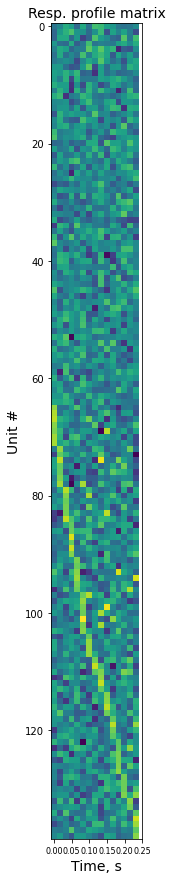

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 15))

ax.imshow(profile_mx_half_s)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xticks(np.arange(len(bins_prof[15::3]))*3)
_ = ax.set_xticklabels(["%.2f" % b for b in bins_prof[15::3]], fontsize=8)
#ax.axvline(15, color='black', ls='--')
ax.set_title("Resp. profile matrix", fontsize=14)

#fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'response_profile_matrix_small.png'), dpi=500)

In [29]:
# for fun - arrange by first highest bin reponse
#idxs = [profile_mx_half[:, i].argmax() for i in range(profile_mx_half.shape[1])]
first_sign_bins = np.zeros(len(unit_names))
for i, unit_name in enumerate(unit_names):
    with h5py.File(h5_file, 'r') as f:
        shuffled_sil = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
        shuffled_bgr = np.array(f['units'][unit_name]['psth_shuffled_micro_in_BGR'])
        profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

    # for silence
    fr_sil_mean = shuffled_sil[:, 1]
    fr_sil_std  = shuffled_sil[:, 2]
    fr_sil_prof = profiles.mean(axis=0)
    prof_sil_z = (fr_sil_prof - fr_sil_mean)/fr_sil_std  # z-scored
    #prof_sil_z /= np.max(np.abs(prof_sil_z), axis=0)      # put bw -1 and 1
    
    # significant bins
    #idxs_non_sign = np.where((fr_sil_prof > shuffled_sil[:, 3]) & (fr_sil_prof < shuffled_sil[:, 4]))[0]
    #idxs_sign = np.array([x for x in range(bc - 1) if x not in idxs_non_sign])
    idxs_sign = np.where((fr_sil_prof > shuffled_sil[:, 4]))[0]
    if len(idxs_sign[idxs_sign > 14]) > 0:
        first_sign_bins[i] = idxs_sign[idxs_sign > 14].min()

## 2.2 Unit activity matrix for selected periods (overlayed)

In [43]:
# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
pulses_silence, pulses_noise, _, _ = build_silence_and_noise_events(tl, s_offset, latency, drift)

event_type = 0  # silence
periods = get_idxs_of_event_periods(tl, event_type)

# periods after noise
noise_p_idxs     = np.array([i for i, p in enumerate(periods) if tl[p[0] - 1][6] < 0])
non_noise_p_idxs = np.array([i for i in range(len(periods)) if not i in noise_p_idxs])

# remove those from analysis?
#periods = periods[non_noise_p_idxs]

# select only 50% of periods
split_ratio = 0.5
train_count = int(len(periods)*split_ratio)
train_idxs  = np.random.choice(np.arange(len(periods)), train_count, replace=False)
train_idxs.sort()

# or after noise
train_idxs = noise_p_idxs

bin_size = 0.05/3
bc_amx   = int(30*(1/bin_size))  # 30 secs
bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx+1)
pulses_over, unit_AM = get_unit_AM_for_periods(tl, periods[train_idxs], pulses_silence, spike_times, bins_amx, mode='overlay')

In [44]:
unit_AM_s = unit_AM[sort_index]

Text(0.5, 0, 'Time in silence, s')

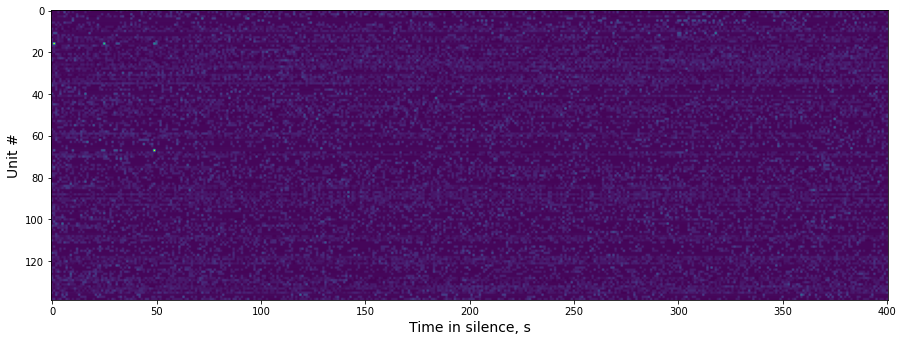

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(unit_AM_s[:, 0:401])  # just created
#ax.imshow(unit_amx_all[10][:40, 0:600])  # got from the file
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xlabel('Time in silence, s', fontsize=14)  
#_ = ax.set_xticks(np.arange(0, 600, 30))
#_ = ax.set_xticklabels(np.arange(0, 10, 0.5), fontsize=10)
#_ = ax.set_xticks(np.arange(len(bins_amx[::30])))
#_ = ax.set_xticklabels(["%.2f" % b for b in bins_amx[::30]], fontsize=8)
#ax.set_xlim(0, 600)

#fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'unit_AM_10sec.png'), dpi=500)

## 2.3 Population reponse

In [297]:
# create shuffled unit AM
unit_AM_shuf = unit_AM.copy().T
np.random.shuffle(unit_AM_shuf)
unit_AM_shuf = unit_AM_shuf.T
unit_AM_shuf.shape

(40, 1800)

In [51]:
# CCR matrix for all units
CCR_mx = np.zeros(unit_AM.shape)
for unit_idx in range(len(profile_mx_half)):
    prof = profile_mx_half_s[unit_idx]
    spks = unit_AM_s[unit_idx]
    #spks = unit_AM_shuf[unit_idx]
    CCR_mx[unit_idx] = signal.correlate(spks, prof, mode='same')

# 03 - CCR Matrix analysis

In [58]:
session = sessions[10]
session

'009266_hippoSIT_2023-04-26_08-20-17'

In [59]:
# read from file
animal         = session.split('_')[0]
metronome_file = os.path.join(source, animal, session, 'metronome.h5')

# shuffled signals
with h5py.File(metronome_file, 'r') as f:
    CCR_mx_all_shuf = np.array(f['CCR_mx_silence_after_noise_shuf'])
sig_shuf      = CCR_mx_all_shuf.mean(axis=1) # 1000 signals for shuffled activity matrices
sig_shuf_mean = CCR_mx_all_shuf.mean(axis=(0, 1))  # shuffled mean
del CCR_mx_all_shuf

# shuffled percentiles
confidence_low  = np.zeros(sig_shuf.shape[1])
confidence_high = np.zeros(sig_shuf.shape[1])
for i, col in enumerate(sig_shuf.T):
    confidence_low[i]  = np.percentile(col, 5)
    confidence_high[i] = np.percentile(col, 95)    

# original signal
with h5py.File(metronome_file, 'r') as f:
    CCR_mx_all = np.array(f['CCR_mx_silence_after_noise'])
sig      = CCR_mx_all.mean(axis=0)      # basically an averaged CCR matrix
sig_mean = CCR_mx_all.mean(axis=(0, 1)) # mean population signal
    
# original unit activity matrices
with h5py.File(metronome_file, 'r') as f:
    unit_amx_all = np.array(f['unit_amx_silence_after_noise'])
    
CCR_mx_all.shape  # iterations, units, spiking bins

(100, 53, 1800)

In [60]:
# select one CCR matrix to plot
iter_id = 0  # id of the random 50% selection of silence periods
CCR_mx  = CCR_mx_all[iter_id]
unit_AM = unit_amx_all[iter_id]

# pulses for overlayed population are always adjusted to zero
pulses_pop = np.linspace(0, 30, 30*4+1) + 0.11  # half a period to align nicely

# bins for CCR matrix
bin_size = 0.05/3
bc_amx   = int(30*(1/bin_size))  # 30 secs
bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx+1)

# bins for profile
bins_prof = np.linspace(-0.25, 0.25, 31)

## 3.1 Plot single CCR matrix

In [62]:
CCR_mx_f = CCR_mx.copy()
CCR_mx_f[CCR_mx_f > 25] = 25
CCR_mx_f[CCR_mx_f < -25] = -25

Text(0.5, 0, 'Time in silence, s')

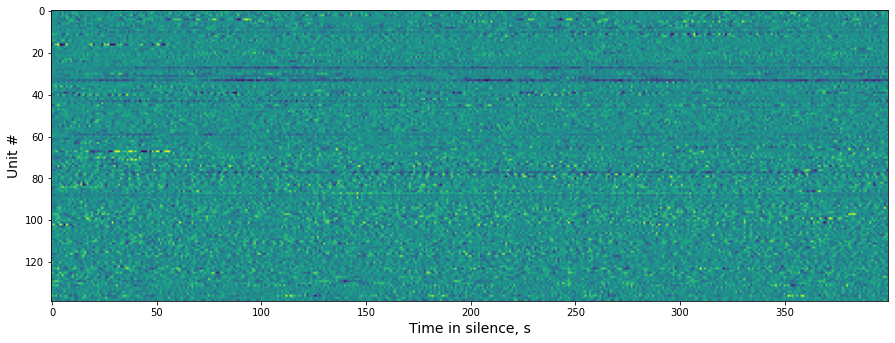

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(CCR_mx_f[:, 0:400])  # got from the file
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xlabel('Time in silence, s', fontsize=14)  
#_ = ax.set_xticks(np.arange(0, 600, 30))
#_ = ax.set_xticklabels(np.arange(0, 10, 0.5), fontsize=10)
#ax.set_xlim(0, 600)

#fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'CCR_mx_10sec.png'), dpi=500)

## 3.2 Population signal (single iteration)

In [57]:
# create population activity signal
sig = CCR_mx.mean(axis=0)
unit_am_sig = unit_AM.mean(axis=0)

# bandpass filter 3 - 5 Hz
low_cut, high_cut = 3, 5  # Hz
low_cut, high_cut = 1, 29  # Hz
s_rate = 60
sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
sig_filt = signal.sosfiltfilt(sos, sig)
unit_am_sig_filt = signal.sosfiltfilt(sos, unit_am_sig)

# hilbert transform
analytic_signal = signal.hilbert(sig_filt)  
amplitude_envelope = np.abs(analytic_signal)  # amplitude envelope
instantaneous_phase = np.angle(analytic_signal)  # instantaneous phase

NameError: name 'pulses_pop' is not defined

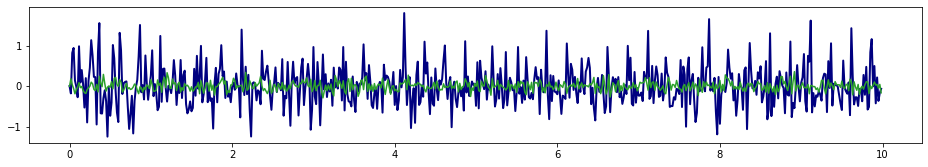

In [58]:
# a good example: 009265_hippoSIT_2023-03-02_16-27-42
fig, ax = plt.subplots(1, 1, figsize=(16, 2.5))

x_l, x_r = 0, 600
ax.plot(bins_amx[x_l:x_r], sig_filt[x_l:x_r], color='navy', lw=2, label='Transformed')  # filtered to remove noise
ax.plot(bins_amx[x_l:x_r], unit_am_sig_filt[x_l:x_r], color='tab:green', label='Original')  # filtered to remove noise
#ax.scatter(bins_amx[x_l:x_r][::14], instantaneous_phase[x_l:x_r][::14], label='phase')
#ax.plot(bins_amx[x_l:x_r], amplitude_envelope[x_l:x_r], label='envelope')
ax.vlines(pulses_pop, sig_filt.min(), sig_filt.max(), color='black', lw=1, ls='--', label='"Fake" stim.')
ax.set_xlim(bins_amx[x_l], bins_amx[x_r])
ax.axhline(0, color='black')
ax.set_xlabel('Time in silence, s', fontsize=14)
ax.set_ylabel('Z-scored response', fontsize=14)
#ax.set_title('Population activity', fontsize=14)
ax.legend(loc='lower right')
ax.set_ylim(-1.8, 2.5)

fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'pop_act_with_trans_10sec.png'), dpi=500)

## 3.3 Population average (100 iterations)

In [61]:
# filter out low freq noise
low_cut, high_cut = 1, 29  # Hz
s_rate = 60
sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
sig_filt         = signal.sosfiltfilt(sos, sig_mean)
sig_filt_shuf    = signal.sosfiltfilt(sos, sig_shuf_mean)
unit_am_sig_filt_mean = signal.sosfiltfilt(sos, unit_amx_all.mean(axis=(0, 1)))

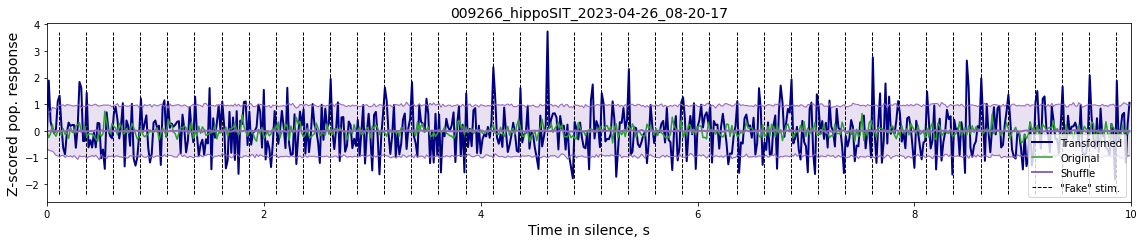

In [62]:
# a good example: 009265_hippoSIT_2023-03-02_16-27-42?
fig, ax = plt.subplots(1, 1, figsize=(16, 3.5))

x_l, x_r = 0, 600
x_vals = bins_amx[x_l:x_r]
ax.plot(x_vals, sig_filt[x_l:x_r], color='navy', lw=2, label='Transformed')
ax.plot(x_vals, unit_am_sig_filt_mean[x_l:x_r], color='tab:green', label='Original')
ax.plot(x_vals, sig_filt_shuf[x_l:x_r], color='tab:purple', lw=2, label='Shuffle')
ax.plot(x_vals, confidence_low[x_l:x_r], lw=1, color='tab:purple')
ax.plot(x_vals, confidence_high[x_l:x_r], lw=1, color='tab:purple')
ax.fill_between(x_vals, confidence_low[x_l:x_r], confidence_high[x_l:x_r], color='tab:purple', alpha=0.2)
ax.vlines(pulses_pop, sig_filt.min(), sig_filt.max(), color='black', lw=1, ls='--', label='"Fake" stim.')
ax.set_xlim(bins_amx[x_l], bins_amx[x_r])
ax.set_xlabel('Time in silence, s', fontsize=14)
ax.set_ylabel('Z-scored pop. response', fontsize=14)
ax.set_title(session, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'metronome_noise_ex5.png'), dpi=500)

## 3.4 P(F)STH for population signal

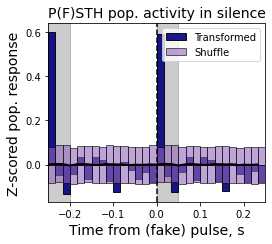

In [64]:
def get_psth(pulses, sig):
    rec_count = len(pulses) - 3
    psth_sig = np.zeros([rec_count, 30])
    for i in np.arange(rec_count) + 1:
        psth_sig[i-1] = sig[i*15 - 8:i*15 + 22]
    return psth_sig.mean(axis=0)#/len(psth_sig)

# PSTH for original CCR
psth_sig_mean = get_psth(pulses_pop, sig_filt)

# P(F)STH for shuffle
psth_sigs_shuf = np.zeros([len(sig_shuf), 30])
for i, sig_curr in enumerate(sig_shuf):
    psth_sigs_shuf[i] = get_psth(pulses_pop, sig_curr)

# percentiles
c_psth_shuf_low  = np.zeros(psth_sigs_shuf.shape[1])
c_psth_shuf_high = np.zeros(psth_sigs_shuf.shape[1])
for i, col in enumerate(psth_sigs_shuf.T):
    c_psth_shuf_low[i]  = np.percentile(col, 5)
    c_psth_shuf_high[i] = np.percentile(col, 95) 
    
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.axvspan(0, 0.05, alpha=0.2, color='black')
ax.axvspan(-0.25, -0.2, alpha=0.2, color='black')
ax.hist(bins_prof[:-1], bins=bins_prof, weights=psth_sig_mean, edgecolor='black', color='navy', alpha=0.9, label='Transformed')
ax.hist(bins_prof[:-1], bins=bins_prof, weights=c_psth_shuf_high, edgecolor='black', color='tab:purple', alpha=0.6, label='Shuffle')
ax.hist(bins_prof[:-1], bins=bins_prof, weights=c_psth_shuf_low, edgecolor='black', color='tab:purple', alpha=0.6)
ax.plot(bins_prof[:-1], psth_sigs_shuf.mean(axis=0), color='black', lw=2)
ax.axvline(0, color='black', ls='--')
ax.set_title('P(F)STH pop. activity in silence', fontsize=14)
ax.set_xlabel('Time from (fake) pulse, s', fontsize=14)
ax.set_ylabel('Z-scored pop. response', fontsize=14)
ax.set_xlim(-0.25, 0.25)
ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'PFSTH_noise_ex5.png'), dpi=500)

## 3.3 Power spectrum

/tmp/ipykernel_238257/701802941.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  _, shuffle_powers[i] = get_power_spectrum(sig_curr[bl:br], s_rate=s_rate)  # first 20 secs
/tmp/ipykernel_238257/701802941.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  _, unit_amx_powers[i] = get_power_spectrum(sig_curr[bl:br], s_rate=s_rate)  # first 20 secs
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


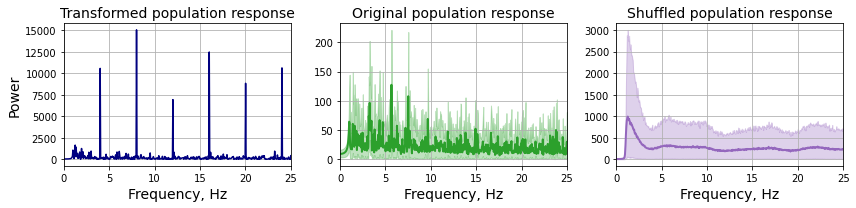

In [214]:
bl, br = 0, 1200  # range in bins to compute FFT

# population activity spectrum
freqs, powers = get_power_spectrum(sig_filt[bl:br], s_rate=s_rate)  # first 20 secs

# random shuffles
shuffle_powers = np.zeros([len(sig_shuf), int(br/2)])
for i, shuf_curr in enumerate(sig_shuf):
    sig_curr = signal.sosfiltfilt(sos, shuf_curr)
    _, shuffle_powers[i] = get_power_spectrum(sig_curr[bl:br], s_rate=s_rate)  # first 20 secs
# percentiles for shuffles
c_powers_shuf_low  = np.zeros(shuffle_powers.shape[1])
c_powers_shuf_high = np.zeros(shuffle_powers.shape[1])
for i, col in enumerate(shuffle_powers.T):
    c_powers_shuf_low[i]  = np.percentile(col, 5)
    c_powers_shuf_high[i] = np.percentile(col, 95) 

# average for original activity matrix
unit_amx_powers = np.zeros([len(unit_amx_all), int(br/2)])
for i, unit_am_curr in enumerate(unit_amx_all):
    sig_curr = signal.sosfiltfilt(sos, unit_am_curr.mean(axis=0))
    _, unit_amx_powers[i] = get_power_spectrum(sig_curr[bl:br], s_rate=s_rate)  # first 20 secs
# percentiles for unit AM powers
c_powers_am_low  = np.zeros(unit_amx_powers.shape[1])
c_powers_am_high = np.zeros(unit_amx_powers.shape[1])
for i, col in enumerate(unit_amx_powers.T):
    c_powers_am_low[i]   = np.percentile(col, 5)
    c_powers_am_high[i] = np.percentile(col, 95) 

    
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# power of the metronome
ax = axes[0]
ax.plot(freqs, powers, color='navy')
ax.set_title('Transformed population response', fontsize=14)

# powers of unit AM
ax = axes[1]
ax.plot(freqs, unit_amx_powers.mean(axis=0), lw=2, color='tab:green')
ax.fill_between(freqs, c_powers_am_low, c_powers_am_high, color='tab:green', alpha=0.3)
ax.set_title('Original population response', fontsize=14)

# powers of shuffle
ax = axes[2]
ax.plot(freqs, shuffle_powers.mean(axis=0), lw=2, color='tab:purple')
ax.fill_between(freqs, c_powers_shuf_low, c_powers_shuf_high, color='tab:purple', alpha=0.3)
ax.set_title('Shuffled population response', fontsize=14)

for i, ax in enumerate(axes):
    ax.set_xlim(0, 25)
    ax.grid()
    ax.set_xlabel('Frequency, Hz', fontsize=14)
    if i % 3 == 0:
        ax.set_ylabel('Power', fontsize=14)
        
fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'powers_PFSTH_pop.png'), dpi=500)

## LFP Power spectrum (TODO remove away)

In [122]:
periods_bgr = periods = get_idxs_of_event_periods(tl, 1)
periods_sil = periods = get_idxs_of_event_periods(tl, 0)

bgr_dur = np.array([(tl[p[1]][0] - tl[p[0]][0]) for p in periods_bgr]).sum()
sil_dur = np.array([(tl[p[1]][0] - tl[p[0]][0]) for p in periods_sil]).sum()
bgr_dur, sil_dur

(1317.1000270676668, 785.0859768506964)

In [123]:
p_spec = {}
for i, (area, lfp) in enumerate(session_data['lfp'].items()):
    lfp_bgr = np.concatenate([( lfp[ p[0]*10 : p[1]*10 ] ) for p in periods_bgr])
    lfp_sil = np.concatenate([( lfp[ p[0]*10 : p[1]*10 ] ) for p in periods_sil])
    
    fbgr, pbgr = get_power_spectrum(lfp_bgr, s_rate=1000)  # 1000 Hz s_rate LFP
    fsil, psil = get_power_spectrum(lfp_sil, s_rate=1000)  # 1000 Hz s_rate LFP

    p_spec[area] = {
        'fbgr': fbgr,
        'pbgr': pbgr/bgr_dur,
        'fsil': fsil,
        'psil': psil/sil_dur,
    }

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


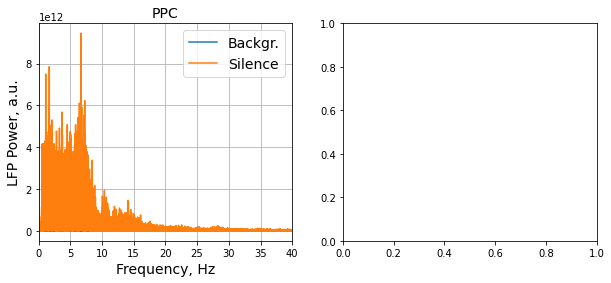

In [126]:
# power spectrum for raw LFP in silence
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, (area, p_spec_data) in enumerate(p_spec.items()):
    ax = axes[i]
    ax.plot(p_spec_data['fbgr'], p_spec_data['pbgr'], label='Backgr.')
    ax.plot(p_spec_data['fsil'], p_spec_data['psil'], label='Silence')
    ax.set_xlim(0, 40)
    ax.grid()
    ax.set_xlabel('Frequency, Hz', fontsize=14)
    if i == 0:
        ax.set_ylabel('LFP Power, a.u.', fontsize=14)
    ax.set_title(area, fontsize=14)
    ax.legend(loc='upper right', fontsize=14)

## Predictions

In [127]:
# precision in tim prediction in cycles
max_bin = 1201  # max time - 20 seconds
(np.diff(instantaneous_phase[:max_bin]) < 0).sum(), int(np.ceil((bins_amx[max_bin] - bins_amx[0])*4))

(374, 81)

In [128]:
# polar plot phase values from real pulses, do rayleigh test
sel_pulses = pulses_over[pulses_over < 20]
sel_pulse_idxs = (sel_pulses/bin_size).astype(np.int32)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

rho = amplitude_envelope[sel_pulse_idxs]
phi = instantaneous_phase[sel_pulse_idxs]
x, y = pol2cart(rho, phi)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='polar')
ax.scatter(x, y)
ax.set_title('Inst. phase for fake pulses', fontsize=14)

NameError: name 'bin_size' is not defined

In [305]:
# phase value vs cycle index in time, look at diff sil segments
# or just time diffs between inst phase and real pulses
peak_idxs = np.where(np.diff(instantaneous_phase) < 0)[0]

# select longest
len_max = len(sel_pulses) if len(sel_pulses) < len(peak_idxs) else len(peak_idxs)
times_from_units = (peak_idxs*bin_size)[:len_max]
times_from_pulse = sel_pulses[:len_max]
to_zero = times_from_units[0] - times_from_pulse[0]
discrepancy = times_from_pulse - times_from_units + to_zero

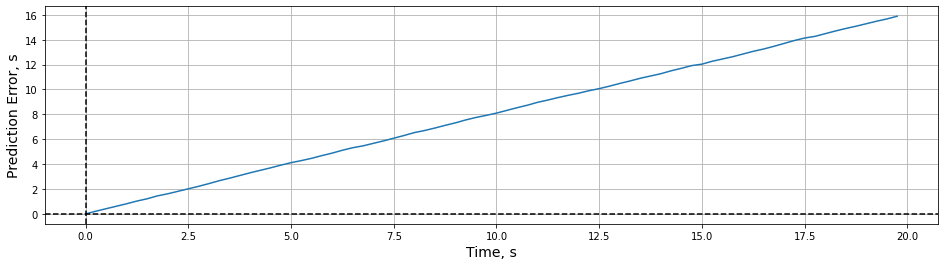

In [306]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(np.arange(len(discrepancy))/4, discrepancy)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Prediction Error, s', fontsize=14)
ax.axhline(0, color='black', ls='--')
ax.axvline(0, color='black', ls='--')
ax.grid()